# Imports

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_12482/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("tree_1.rds")

In [5]:
%%R
str(data)

List of 17
 $ id                   : chr "synthetic/splatter/tree_1"
 $ cell_ids             : chr [1:918] "Cell1" "Cell2" "Cell3" "Cell4" ...
 $ cell_info            : NULL
 $ counts               : num [1:918, 1:1254] 1 14 3 22 13 9 6 14 6 2 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:918] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene6557" "Gene460" "Gene5076" "Gene7527" ...
 $ expression           : num [1:918, 1:1254] 0.822 3.672 2.067 4.542 3.162 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:918] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene6557" "Gene460" "Gene5076" "Gene7527" ...
 $ feature_info         : tibble [1,254 × 1] (S3: tbl_df/tbl/data.frame)
  ..$ feature_id: chr [1:1254] "Gene6557" "Gene460" "Gene5076" "Gene7527" ...
 $ milestone_ids        : chr [1:15] "M1" "M3" "M5" "M7" ...
 $ milestone_network    : tibble [14 × 4] (S3: tbl_df/tbl/data.frame)
  ..$ from    : chr [1:14] "M1" "M3" "M3" "M5" ...
  ..$ t

In [6]:
%%R
counts <- data$counts
expression <- data$expression

In [7]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [8]:
%%R --o grouping
grouping <- data$grouping

In [9]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id,
    end_id = data$prior_information$end_id,
    groups_id = data$prior_information$groups_id,
    end_n = data$prior_information$end_n,
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

# Working Models - Scorpius, Angle, PAGA, PAGA Tree, MST, DPT, Component1, Matcher

In [10]:
%%R
umap_dimred <- dyndimred::dimred_umap(dataset$expression)

Loading required namespace: uwot


In [11]:
%%R
pca_dimred <- dyndimred::dimred_pca(dataset$expression)

# Scorpius

In [12]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))

You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


Coloring by milestone
Using milestone_percentages from trajectory


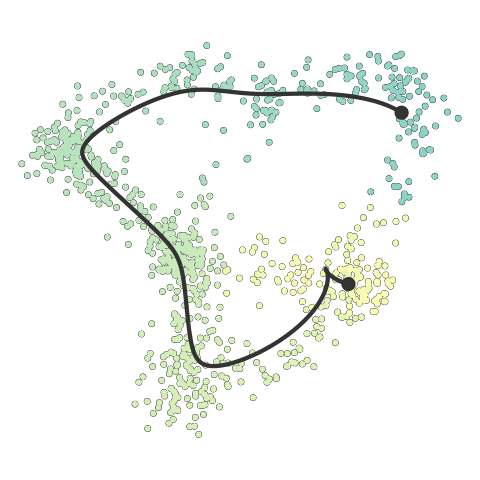

In [13]:
%%R
plot_dimred(scorpius_model, grouping=grouping)

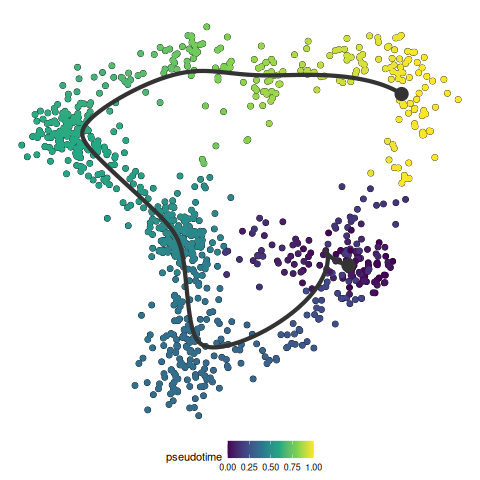

In [14]:
%%R
plot_dimred(scorpius_model, color_cells=c("pseudotime"))

# PAGA

In [15]:
%%R
paga_model <- infer_trajectory(dataset, ti_paga(), give_priors = c("start_id","end_id","groups_id"))

Coloring by milestone
Using milestone_percentages from trajectory


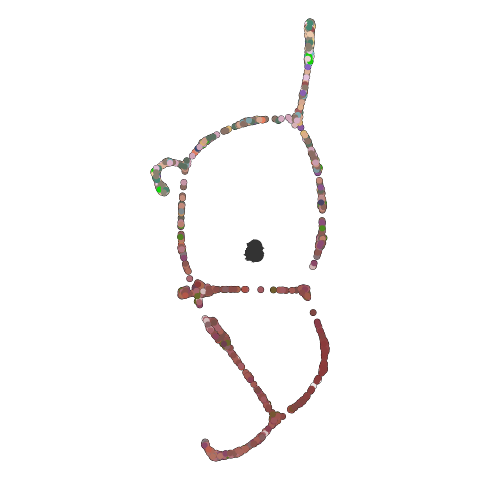

In [16]:
%%R
plot_dimred(paga_model, grouping=grouping)

Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using '2' as root
In addition: Warning message:
In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.


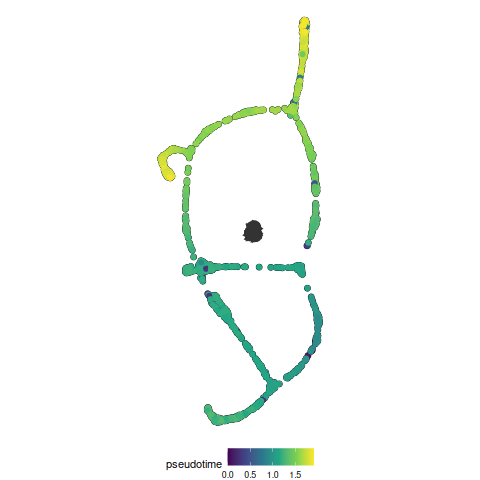

In [17]:
%%R
plot_dimred(paga_model, color_cells=c("pseudotime"))

# Angle

In [18]:
%%R
angle_model <- infer_trajectory(dataset, ti_angle(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


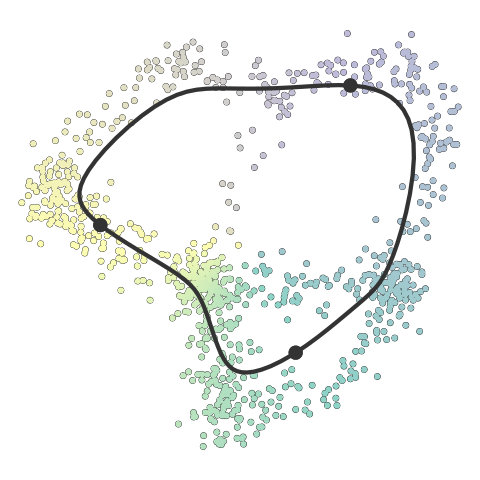

In [19]:
%%R
plot_dimred(angle_model, grouping=grouping)

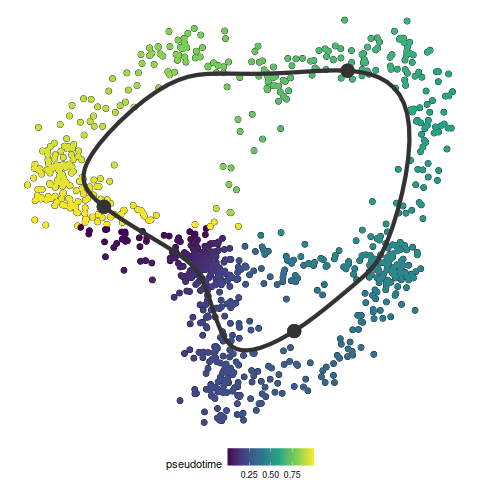

In [20]:
%%R
plot_dimred(angle_model, color_cells=c("pseudotime"))

# PAGA Tree

In [21]:
%%R
paga_tree_model <- infer_trajectory(dataset, ti_paga_tree(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


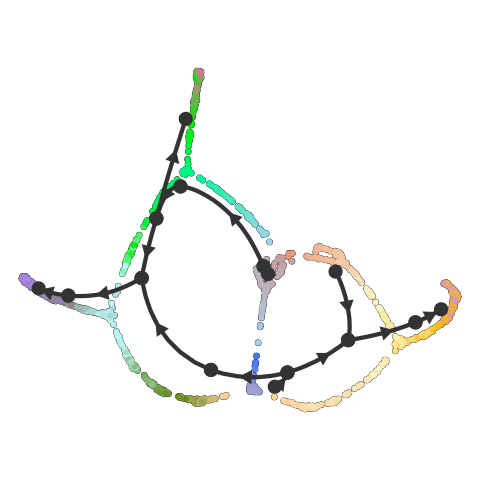

In [22]:
%%R
plot_dimred(paga_tree_model, grouping=grouping)

Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using '1' as root
In addition: Warning message:
In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.


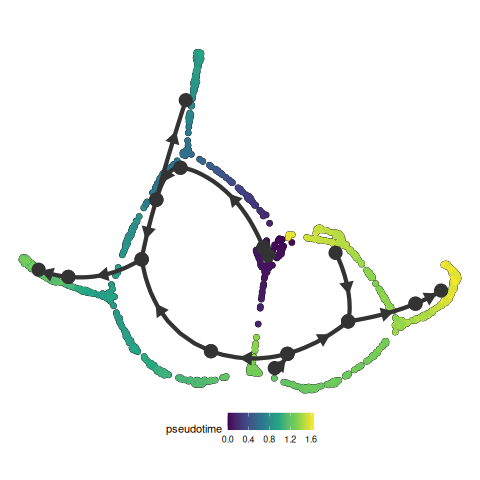

In [23]:
%%R
plot_dimred(paga_tree_model, color_cells=c("pseudotime"))

# MST

In [24]:
%%R
mst_model <- infer_trajectory(dataset, ti_mst(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


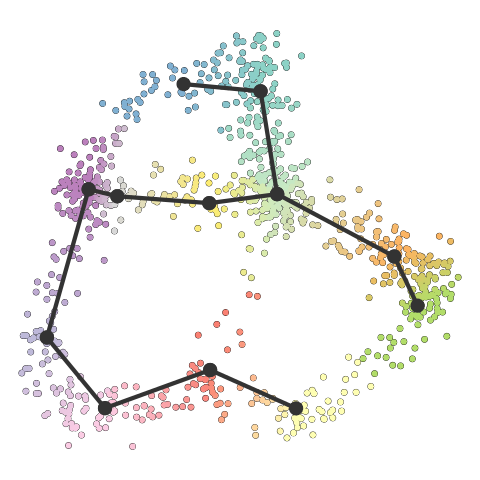

In [25]:
%%R
plot_dimred(mst_model, grouping=grouping)

Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using 'M1' as root
In addition: Warning message:
In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.


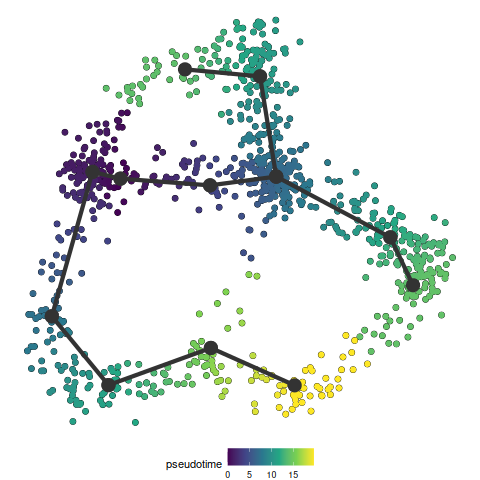

In [26]:
%%R
plot_dimred(mst_model, color_cells=c("pseudotime"))

# DPT

In [27]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


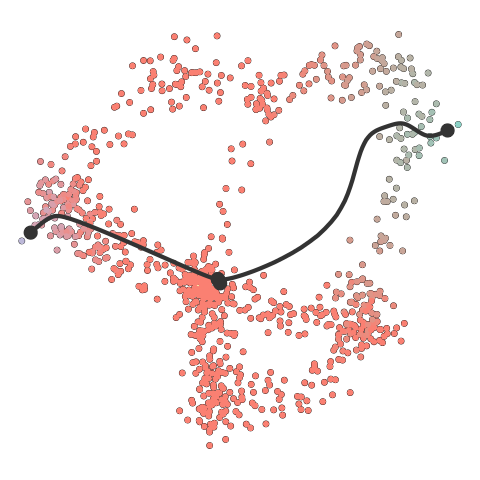

In [28]:
%%R
plot_dimred(dpt_model, grouping=grouping)

Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using 'Tip0' as root
In addition: Warning message:
In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.


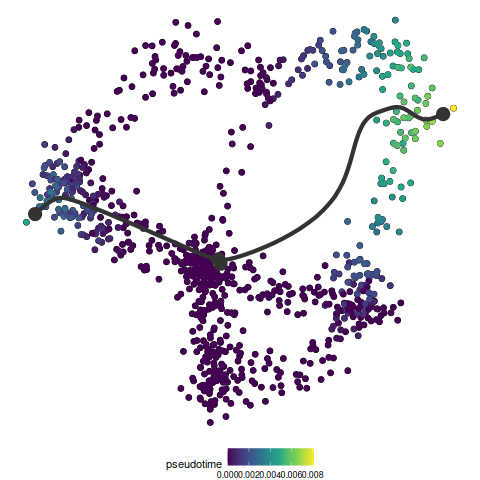

In [29]:
%%R
plot_dimred(dpt_model, color_cells=c("pseudotime"))

# Component1

In [30]:
%%R
comp1_model <- infer_trajectory(dataset, ti_comp1(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


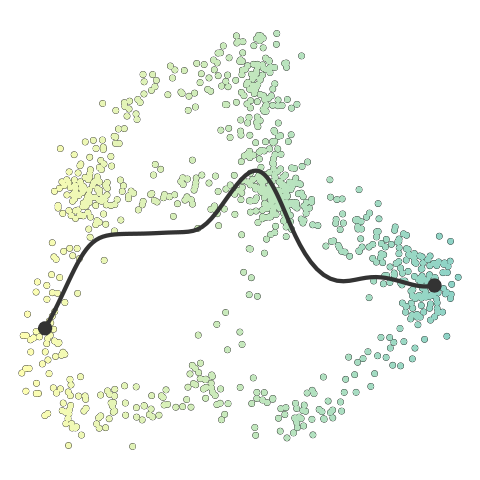

In [31]:
%%R
plot_dimred(comp1_model, grouping=grouping)

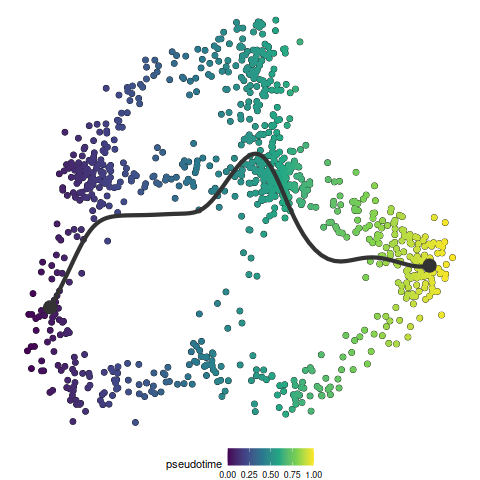

In [32]:
%%R
plot_dimred(comp1_model, color_cells=c("pseudotime"))

# Matcher

In [33]:
%%R
matcher_model <- infer_trajectory(dataset, ti_matcher(), give_priors = c("start_id"))

Coloring by milestone
Using milestone_percentages from trajectory


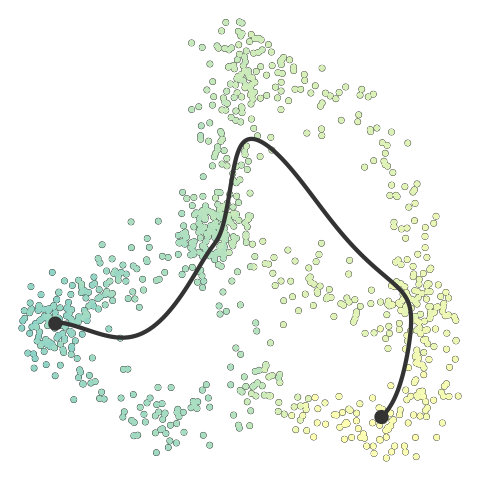

In [34]:
%%R
plot_dimred(matcher_model, expression=data$expression, grouping=grouping)

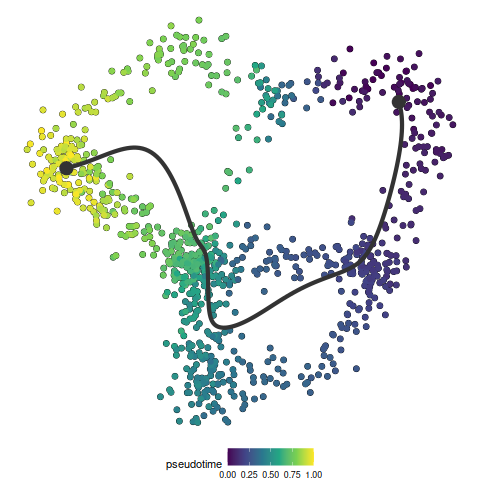

In [35]:
%%R
plot_dimred(matcher_model, expression=data$expression, color_cells=c("pseudotime"))

# Plots

In [36]:
# Scorpius, Angle, PAGA, PAGA Tree, MST, DPT, Component1, Matcher

In [37]:
%%R
library(gridExtra)


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using '1' as root
Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using 'M1' as root
Pseudotime not provided, will calculate pseudotime from root milestone
root cell or milestone not provided, trying first outgoing milestone_id
Using 'Tip0' as root
In addition: Warning messages:
1: In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.
2: In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dynwrap::add_root(). This will result in an error in future releases.
3: In dynwrap::calculate_pseudotime(trajectory) :
  Trajectory is not rooted. Add a root to the trajectory using dyn

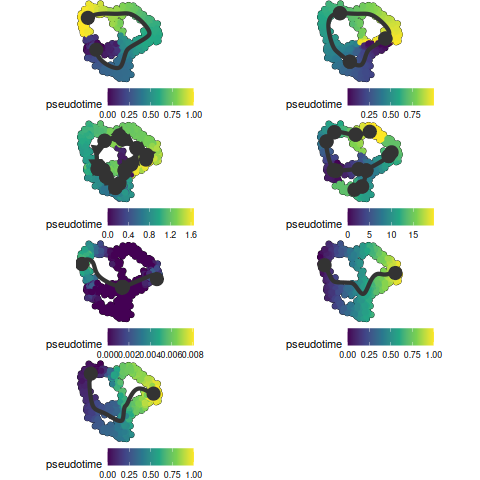

In [38]:
%%R
plt1 <- plot_dimred(scorpius_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt2 <- plot_dimred(angle_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt3 <- plot_dimred(paga_tree_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt4 <- plot_dimred(mst_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt5 <- plot_dimred(dpt_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt6 <- plot_dimred(comp1_model, color_cells=c("pseudotime"), dimred=pca_dimred)
plt7 <- plot_dimred(matcher_model, color_cells=c("pseudotime"), dimred=pca_dimred, expression=data$expression)
grid.arrange(plt1,plt2,plt3,plt4,plt5,plt6,plt7,nrow=4,ncol=2)
# grid.arrange(plt1,plt2,plt3,plt4,plt5,plt6,nrow=3,ncol=2)

Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory
Coloring by milestone
Using milestone_percentages from trajectory


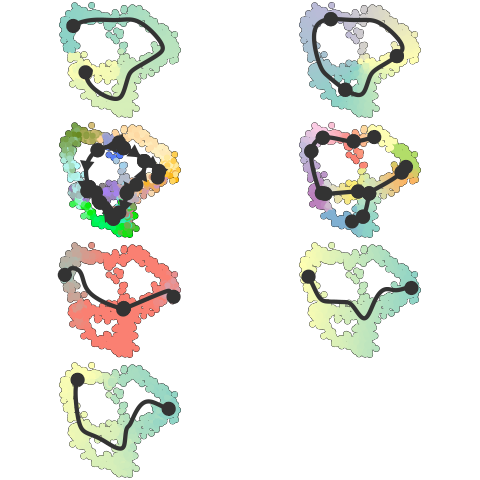

In [39]:
%%R
plt1 <- plot_dimred(scorpius_model, dimred=pca_dimred, grouping=grouping)
plt2 <- plot_dimred(angle_model, dimred=pca_dimred, grouping=grouping)
plt3 <- plot_dimred(paga_tree_model, dimred=pca_dimred, grouping=grouping)
plt4 <- plot_dimred(mst_model, dimred=pca_dimred, grouping=grouping)
plt5 <- plot_dimred(dpt_model, dimred=pca_dimred, grouping=grouping)
plt6 <- plot_dimred(comp1_model, dimred=pca_dimred, grouping=grouping)
plt7 <- plot_dimred(matcher_model, dimred=pca_dimred, expression=data$expression, grouping=grouping)
grid.arrange(plt1,plt2,plt3,plt4,plt5,plt6,plt7,nrow=4,ncol=2)
# grid.arrange(plt1,plt2,plt3,plt4,plt5,plt6,nrow=3,ncol=2)

In [41]:
%%R
names(scorpius_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "feature_ids"                
 [5] "feature_info"                "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "pseudotime"                  "trajectory_type"            
[13] "directed"                    "dimred"                     
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      
